In [1]:
!pip install implicit

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import re

from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix, coo_matrix
import implicit
from implicit import als
from implicit.nearest_neighbours import ItemItemRecommender
from lightgbm import LGBMClassifier

import lightgbm as lgb

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('retail_train.csv')
data_test = pd.read_csv('retail_test1.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy() 
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [5]:
recommender = MainRecommender(data_train_lvl_1, weighting='bm25')

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [6]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [7]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

In [8]:
users_lvl_2['candidates_own_recommendations'] = users_lvl_2['user_id'].apply(lambda x:
                                                                             recommender.get_own_recommendations(x, N=50))
users_lvl_2['candidates_similar_items_recommendation'] = users_lvl_2['user_id'].apply(lambda x:
                                                                                      recommender.get_similar_items_recommendation(x, N=50))
users_lvl_2['candidates_similar_users_recommendation'] = users_lvl_2['user_id'].apply(lambda x:
                                                                                      recommender.get_similar_users_recommendation(x, N=50))
users_lvl_2['candidates_als_recommendations'] = users_lvl_2['user_id'].apply(lambda x:
                                                                             recommender.get_als_recommendations(x, N=50))

In [9]:
result_lvl_1_to_check = pd.merge(result_lvl_1, users_lvl_2, how='inner', on="user_id")
result_lvl_1_to_check.head(2)

,user_id,actual,candidates_own_recommendations,candidates_similar_items_recommendation,candidates_similar_users_recommendation,candidates_als_recommendations
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[1029743, 1029743, 1106523, 5569230, 916122, 8...","[965555, 849559, 917532, 1009977, 1012688, 989..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[1029743, 1029743, 1106523, 5569230, 916122, 8...","[851819, 969725, 1006063, 873577, 962266, 9474..."


In [10]:
for variant in result_lvl_1_to_check.columns[2:6]:
    print(f"{variant}: {result_lvl_1_to_check.apply(lambda row: recall_at_k(row[variant], row['actual'], k=50), axis=1).mean()}")

candidates_own_recommendations: 0.055431256385437985
candidates_similar_items_recommendation: 0.04323684353105271
candidates_similar_users_recommendation: 0.04846367580858733
candidates_als_recommendations: 0.003104124060014693


In [11]:
k_values = [50, 100, 200, 500, 700]
for value in k_values:
    result_lvl_1_to_check[f'candidates_sim_users_k_{value}'] = result_lvl_1_to_check['user_id'].apply(lambda x:
                                                                                                      recommender.get_similar_users_recommendation(x, N=value))

In [12]:
i=0
recall_values = []
for variant in result_lvl_1_to_check.columns[6:]:
    res = result_lvl_1_to_check.apply(lambda row: recall_at_k(row[variant], row['actual'], k=k_values[i]), axis=1).mean()
    print(f"{variant}: {res}")
    recall_values.append(res)
    i += 1

candidates_sim_users_k_50: 0.04846367580858733
candidates_sim_users_k_100: 0.06726412270832476
candidates_sim_users_k_200: 0.09501216975107396
candidates_sim_users_k_500: 0.13755232913065268
candidates_sim_users_k_700: 0.15796522298937954


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


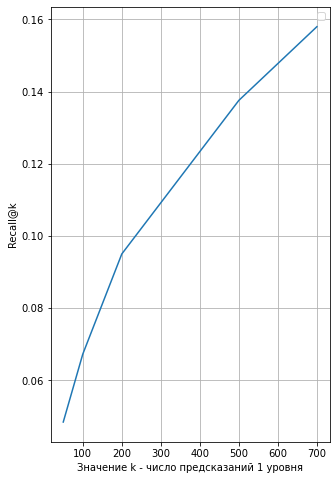

In [13]:
plt.rcParams['figure.figsize'] = 5, 8

plt.plot(k_values, recall_values)

plt.xlabel('Значение k - число предсказаний 1 уровня')
plt.ylabel('Recall@k')

plt.legend()
plt.grid()

plt.show()

In [14]:
def feature_generation(data_train_lvl_2):

    users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
    users_lvl_2.columns = ['user_id']

   
    train_users = data_train_lvl_2['user_id'].unique()
    users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]
    users_lvl_2['candidates_similar_users_recommendation'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))
    
    df = pd.DataFrame({'user_id':users_lvl_2.user_id.values.repeat(len(users_lvl_2.candidates_similar_users_recommendation[0])),
                 'item_id':np.concatenate(users_lvl_2.candidates_similar_users_recommendation.values)})
    targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()

    targets_lvl_2['target'] = 1 
    targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
    targets_lvl_2['target'].fillna(0, inplace= True)

    targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
    targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

    data_merged = pd.merge(data_train_lvl_2, item_features[['item_id', 'department', 'commodity_desc']], how='left', on="item_id")
    data_merged = pd.merge(data_merged, user_features, how='left', on="user_id")
    
    # Цена / Средняя цена товара в категории
    mean_sales_value_in_department = data_merged.groupby(['department'], as_index=False).agg({'sales_value':'mean'})\
                       .rename(columns={'sales_value':'mean_sales_value_in_department'})
    data_merged = data_merged.merge(mean_sales_value_in_department, on='department', how='left')
    data_merged['item_value_div_mean_sales_value_in_department'] = data_merged['sales_value'] / data_merged['mean_sales_value_in_department']
    average_item_value_div_mean_sales_value_in_department = data_merged[['item_value_div_mean_sales_value_in_department', 'user_id', 'item_id']].groupby(['user_id', 'item_id'], as_index=False).agg({'item_value_div_mean_sales_value_in_department':'mean'})
    targets_lvl_2 = targets_lvl_2.merge(average_item_value_div_mean_sales_value_in_department, on=['user_id', 'item_id'], how='left')

    # Кол-во покупок в неделю
    purchases_count_in_week = data_merged.groupby(['item_id', 'week_no'], as_index=False).agg({'sales_value':'count'})\
                       .rename(columns={'sales_value':'purchases_count_in_week'})
    mean_purchases_count_in_week = purchases_count_in_week.groupby(['item_id'], as_index=False).agg({'purchases_count_in_week':'mean'})\
                       .rename(columns={'purchases_count_in_week':'mean_purchases_count_in_week'})
    mean_purchases_count_in_week.sort_values(['mean_purchases_count_in_week'],ascending=False).head()
    targets_lvl_2 = targets_lvl_2.merge(mean_purchases_count_in_week, on='item_id', how='left')

    # Частотность покупок раз в месяц
    sales_value_on_week = data_merged.groupby(['user_id', 'week_no'], as_index=False).agg({'sales_value':'sum'})\
                       .rename(columns={'sales_value':'sales_value_on_week'})
    week_quantity_on_user = sales_value_on_week.groupby(['user_id'], as_index=False).agg({'week_no':'count'})\
                       .rename(columns={'week_no':'week_quantity_on_user'})
    week_quantity_on_user['purchases_frequency_in_a_month'] = week_quantity_on_user['week_quantity_on_user'] / len(data_merged.week_no.unique()) * 4
    targets_lvl_2 = targets_lvl_2.merge(week_quantity_on_user[['user_id', 'purchases_frequency_in_a_month']], on='user_id', how='left')

    # Средний чек
    sales_value_on_basket = data_merged.groupby(['user_id', 'basket_id'], as_index=False).agg({'sales_value':'sum'})\
                       .rename(columns={'sales_value':'sales_value_on_basket'})
    average_check = sales_value_on_basket.groupby(['user_id'], as_index=False).agg({'sales_value_on_basket':'mean'})\
                       .rename(columns={'sales_value_on_basket':'average_check'})
    targets_lvl_2 = targets_lvl_2.merge(average_check, on='user_id', how='left')

    # Кол-во покупок юзером конкретной категории в неделю / Среднее кол-во покупок всеми юзерами конкретной категории в неделю
    purchases_in_dept_by_user = data_merged.groupby(['user_id', 'department'], as_index=False).agg({'sales_value':'count'})\
                       .rename(columns={'sales_value':'purchases_in_dept_by_user'})
    week_count = data_merged.groupby(['user_id'], as_index=False)['week_no'].nunique().rename(columns={'week_no':'week_count'})
    purchases_in_dept_by_user_in_week = purchases_in_dept_by_user.merge(week_count, how='left', on="user_id")
    purchases_in_dept_by_user_in_week['purchases_in_dept_by_user_in_week'] = purchases_in_dept_by_user_in_week['purchases_in_dept_by_user'] / purchases_in_dept_by_user_in_week['week_count']
    purchases_in_dept_all = data_merged.groupby(['department'], as_index=False).agg({'sales_value':'count'})\
                       .rename(columns={'sales_value':'purchases_in_dept_all'})
    purchases_in_dept_all['purchases_in_dept_all_in_week'] = purchases_in_dept_all['purchases_in_dept_all'] / len(data_merged.week_no.unique())
    relatively_purchases_in_dept_by_user = purchases_in_dept_by_user_in_week.merge(purchases_in_dept_all, on='department')
    relatively_purchases_in_dept_by_user['relatively_purchases_in_dept_by_user'] = relatively_purchases_in_dept_by_user['purchases_in_dept_by_user_in_week'] / relatively_purchases_in_dept_by_user['purchases_in_dept_all_in_week']
    targets_lvl_2 = targets_lvl_2.merge(relatively_purchases_in_dept_by_user[['user_id', 'department','relatively_purchases_in_dept_by_user']], on=['user_id', 'department'], how='left')

    # Средняя сумма покупки 1 товара в каждой категории 
    mean_sales_value_in_dept = data_merged.groupby(['department'], as_index=False).agg({'sales_value':'mean'})\
                       .rename(columns={'sales_value':'mean_sales_value_in_dept'})
    data_merged = data_merged.merge(mean_sales_value_in_dept, on='department', how='left')
    data_merged['mean_sales_value_in_dept_subtract_sales_value'] = data_merged['mean_sales_value_in_dept'] - data_merged['sales_value']
    mean_sales_value_in_dept_subtract_sales_value = data_merged[['user_id', 'item_id', 'mean_sales_value_in_dept_subtract_sales_value']].groupby(['user_id', 'item_id'], as_index=False).agg({'mean_sales_value_in_dept_subtract_sales_value':'mean'})
    targets_lvl_2 = targets_lvl_2.merge(mean_sales_value_in_dept_subtract_sales_value, on=['user_id', 'item_id'], how='left')

    return targets_lvl_2

In [15]:
data_train_lvl_2 = feature_generation(data_train_lvl_2)

In [16]:
X_train = data_train_lvl_2.drop('target', axis=1)
y_train = data_train_lvl_2[['target']]
X_train.head(2)

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,item_value_div_mean_sales_value_in_department,mean_purchases_count_in_week,purchases_frequency_in_a_month,average_check,relatively_purchases_in_dept_by_user,mean_sales_value_in_dept_subtract_sales_value
0,2070,1029743,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,...,Unknown,Unknown,1,None/Unknown,NaN,179.333333,4.0,14.355581,0.00126,NaN
1,2070,1029743,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,...,Unknown,Unknown,1,None/Unknown,NaN,179.333333,4.0,14.355581,0.00126,NaN


In [17]:
cat_feats = X_train.columns[2:-6].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [18]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

In [19]:
target_probas = pd.DataFrame(data=train_preds[:, 1], columns=['target_probas'])
target_probas.head()

,target_probas
0,0.000004
1,0.000004
2,0.000004
3,0.000004
4,0.999964


In [20]:
targets_lvl_2_probas = pd.concat([data_train_lvl_2, target_probas], axis=1)

In [21]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [22]:
targets_lvl_2_probas.duplicated(subset=['user_id', 'item_id']).sum()

5340

In [23]:
top_5_lvl_2_boosting = targets_lvl_2_probas.sort_values('target_probas', ascending=False).groupby('user_id').head(5)
top_5_lvl_2_boosting.head(8)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,hh_comp_desc,household_size_desc,kid_category_desc,item_value_div_mean_sales_value_in_department,mean_purchases_count_in_week,purchases_frequency_in_a_month,average_check,relatively_purchases_in_dept_by_user,mean_sales_value_in_dept_subtract_sales_value,target_probas
90371,1363,866211,1.0,2,PRODUCE,National,GRAPES,GRAPES WHITE,18 LB,25-34,...,1 Adult Kids,2,1,2.260233,33.333333,1.333333,224.595000,0.001806,-2.916080,0.999964
7370,2264,1126899,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,...,2 Adults No Kids,2,None/Unknown,2.478567,61.166667,4.000000,41.082667,0.001922,-3.743295,0.999964
100077,1890,916122,1.0,4314,MEAT,National,CHICKEN,CHICKEN BREAST BONELESS,,NaN,...,NaN,NaN,NaN,1.292117,48.666667,1.333333,23.435000,0.000539,-1.894519,0.999964
17978,685,880150,1.0,2975,MEAT,National,BEEF,SOUP/STEW,,35-44,...,Single Female,2,None/Unknown,1.030507,14.500000,4.000000,30.135385,0.001617,-0.197852,0.999964
7353,1762,854405,1.0,397,MEAT-PCKGD,National,MEAT - MISC,BREAST - BONELESS(IQF),40 OZ,45-54,...,2 Adults Kids,5+,3+,1.823380,10.166667,4.000000,50.560000,0.002475,-3.156460,0.999964
17977,685,880150,1.0,2975,MEAT,National,BEEF,SOUP/STEW,,35-44,...,Single Female,2,None/Unknown,1.030507,14.500000,4.000000,30.135385,0.001617,-0.197852,0.999964
84668,1858,916122,1.0,4314,MEAT,National,CHICKEN,CHICKEN BREAST BONELESS,,25-34,...,Single Female,1,None/Unknown,0.471823,48.666667,2.000000,66.336667,0.000719,3.425481,0.999964
55923,2275,899624,1.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),10 LB,NaN,...,NaN,NaN,NaN,1.292179,48.833333,4.000000,30.290000,0.000535,-0.676080,0.999964


In [24]:
all_users_list = top_5_lvl_2_boosting['user_id'].drop_duplicates().to_list()
recs = []
for user in all_users_list:
    recs_user = []
    recs_user.append(user)
    recs_user.append(top_5_lvl_2_boosting.loc[top_5_lvl_2_boosting['user_id'] == user, 'item_id'].tolist())
    recs.append(recs_user)
    
top_5_lvl_2_boosting_recs = pd.DataFrame(recs, columns=['user_id', 'top_5_lvl_2_boosting_recs'])
top_5_lvl_2_boosting_recs

,user_id,top_5_lvl_2_boosting_recs
0,1363,"[866211, 1029743, 1029743, 1029743, 1029743]"
1,2264,"[1126899, 916122, 916122, 916122, 916122]"
2,1890,"[916122, 1126899, 834117, 983584, 913210]"
3,685,"[880150, 880150, 880150, 1004906, 866211]"
4,1762,"[854405, 983584, 983584, 983584, 1105488]"
...,...,...
2149,892,"[1029743, 1029743, 1106523, 5569230, 916122]"
2150,312,"[913210, 986912, 933835, 1075368, 1081177]"
2151,1632,"[834117, 965267, 5585510, 6034857, 1081177]"
2152,1799,"[854405, 823704, 1132771, 1122358, 857503]"


In [25]:
result_lvl_2 = pd.merge(result_lvl_2, top_5_lvl_2_boosting_recs, how='inner', on="user_id")
result_lvl_2.head(2)

,user_id,actual,top_5_lvl_2_boosting_recs
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[901062, 1004906, 940947, 940947, 940947]"
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[878996, 5585510, 1081177, 933835, 986912]"


In [26]:
print(f"{result_lvl_2.apply(lambda row: precision_at_k(row['top_5_lvl_2_boosting_recs'], row['actual'], k=5), axis=1).mean()}")


0.2501043841336111


In [27]:
test = feature_generation(data_test)

In [28]:
X_test = test.drop('target', axis=1)
y_test = test[['target']]
X_test.head(2)

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,item_value_div_mean_sales_value_in_department,mean_purchases_count_in_week,purchases_frequency_in_a_month,average_check,relatively_purchases_in_dept_by_user,mean_sales_value_in_dept_subtract_sales_value
0,1340,1029743,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,117.333333,4.0,14.5775,0.000175,NaN
1,1340,1029743,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,117.333333,4.0,14.5775,0.000175,NaN


In [29]:
cat_feats = X_test.columns[2:-6].tolist()
X_test[cat_feats] = X_test[cat_feats].astype('category')

In [30]:
test_preds = lgb.predict_proba(X_test)

In [31]:
target_test_probas = pd.DataFrame(data=test_preds[:, 1], columns=['target_probas'])
target_test_probas.head()

,target_probas
0,0.000004
1,0.000004
2,0.000004
3,0.000004
4,0.000004


In [32]:
targets_lvl_2_probas_test = pd.concat([test, target_test_probas], axis=1)

In [33]:
result_lvl_2_test = data_test.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2_test.columns=['user_id', 'actual']
result_lvl_2_test.head(2)

,user_id,actual
0,1,"[880007, 883616, 931136, 938004, 940947, 94726..."
1,2,"[820165, 820291, 826784, 826835, 829009, 85784..."


In [34]:
targets_lvl_2_probas_test.duplicated(subset=['user_id', 'item_id']).sum()

2798

In [35]:
top_5_lvl_2_boosting_test = targets_lvl_2_probas_test.sort_values('target_probas', ascending=False).groupby('user_id').head(5)
top_5_lvl_2_boosting_test.head(8)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,hh_comp_desc,household_size_desc,kid_category_desc,item_value_div_mean_sales_value_in_department,mean_purchases_count_in_week,purchases_frequency_in_a_month,average_check,relatively_purchases_in_dept_by_user,mean_sales_value_in_dept_subtract_sales_value,target_probas
80554,1640,1106523,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,NaN,...,NaN,NaN,NaN,1.147883,88.000000,2.666667,38.520000,0.000210,-0.372322,0.999964
61626,1568,1004906,1.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,55-64,...,Single Female,1,None/Unknown,1.338010,37.333333,4.000000,73.133333,0.000717,-0.755339,0.999964
39473,575,901062,1.0,2,PRODUCE,National,APPLES,APPLES GALA (BULK&BAG),,35-44,...,Single Female,1,None/Unknown,0.469870,28.333333,4.000000,29.217000,0.000358,1.184661,0.999964
15561,1621,1106523,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,NaN,...,NaN,NaN,NaN,1.310732,88.000000,2.666667,31.912000,0.001947,-0.782322,0.999964
15560,1621,1106523,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,NaN,...,NaN,NaN,NaN,1.310732,88.000000,2.666667,31.912000,0.001947,-0.782322,0.999964
15559,1621,1106523,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,NaN,...,NaN,NaN,NaN,1.310732,88.000000,2.666667,31.912000,0.001947,-0.782322,0.999964
3297,1166,1018740,1.0,3516,DELI,National,DELI MEATS,MEAT:HAM BULK,,45-54,...,2 Adults Kids,3,1,0.599279,13.666667,4.000000,43.134000,0.000960,1.765293,0.999964
30757,1229,1070820,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,55-64,...,2 Adults No Kids,2,None/Unknown,1.147883,43.000000,4.000000,65.005833,0.001561,-0.372322,0.999964


In [36]:
all_users_list = top_5_lvl_2_boosting_test['user_id'].drop_duplicates().to_list()
recs = []
for user in all_users_list:
    recs_user = []
    recs_user.append(user)
    recs_user.append(top_5_lvl_2_boosting_test.loc[top_5_lvl_2_boosting_test['user_id'] == user, 'item_id'].tolist())
    recs.append(recs_user)
    
top_5_lvl_2_boosting_recs = pd.DataFrame(recs, columns=['user_id', 'top_5_lvl_2_boosting_recs'])
top_5_lvl_2_boosting_recs

,user_id,top_5_lvl_2_boosting_recs
0,1640,"[1106523, 5568378, 1122358, 913210, 5569845]"
1,1568,"[1004906, 899624, 874972, 916122, 844179]"
2,575,"[901062, 5569230, 1106523, 1018740, 1101010]"
3,1621,"[1106523, 1106523, 1106523, 1106523, 1101010]"
4,1166,"[1018740, 857503, 899624, 6034857, 878996]"
...,...,...
1880,347,"[844179, 1126899, 1070820, 1127831, 866211]"
1881,1335,"[1106523, 916122, 844179, 1044078, 1126899]"
1882,252,"[913210, 901062, 985999, 908318, 999858]"
1883,1665,"[908318, 901062, 1040807, 1018740, 951412]"


In [37]:
result_lvl_2_test = pd.merge(result_lvl_2_test, top_5_lvl_2_boosting_recs, how='inner', on="user_id")
result_lvl_2_test.head(2)

,user_id,actual,top_5_lvl_2_boosting_recs
0,1,"[880007, 883616, 931136, 938004, 940947, 94726...","[940947, 1004906, 933835, 1018740, 986912]"
1,2,"[820165, 820291, 826784, 826835, 829009, 85784...","[899624, 940947, 866211, 951412, 878996]"


In [38]:
print(f"{result_lvl_2_test.apply(lambda row: precision_at_k(row['top_5_lvl_2_boosting_recs'], row['actual'], k=5), axis=1).mean()}")

0.3781432360742707


In [39]:
result_lvl_2_test[['user_id','top_5_lvl_2_boosting_recs']].to_csv('recommendations.csv')